# https://medium.com/jungle-book/towards-data-set-augmentation-with-gans-9dd64e9628e6
```
## wgan-gp 사용 
## linear + nonlinear 조합으로 생성하니 더 잘되는 경험적느낌
## Slice를 batch size 조절해서 생성 
## Continuous 그냥 생성 / Categorical : Softmax로 생성
```

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from IPython.display import clear_output
iris = datasets.load_iris()


    사용하면 좋은 패키지
    train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


In [2]:
data = iris.data
def sample_data(n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

In [3]:
feature = iris.feature_names

In [4]:
input_dim = np.shape(data)[1] 
latet_dim = 10
BATCH_SIZE = 50
def generator(Z , batch_size , hsize=[15, 20 , 25],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=None)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=None) 
        h2 = tf.layers.dense(h2, hsize[2] , activation = tf.nn.leaky_relu , use_bias=True )  
        #num = tf.slice(h2 , [0,0] , [BATCH_SIZE, 22] )  # 
        #cat = tf.slice(h2 , [0,22] , [BATCH_SIZE, 3] ) # 
        out = tf.layers.dense(h2,  7 , activation = None , use_bias= True )
        num = tf.slice(out , [0,0] , [batch_size, 4] )  # 
        cat = tf.slice(out , [0,4] , [batch_size, 3] ) # 
        Species = tf.nn.softmax(cat)
        num = tf_sqnl(num)
        #out = tf.layers.dense(num ,input_dim , activation = tf_sqnl , use_bias=False , name = 'Numerical' )  # activation=None 
        out = tf.concat([num, Species], axis = 1 , name = "Concat" )
    return out


def discriminator(X,hsize=[16, 16],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu , name = "D1")
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D3" )
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])


In [5]:
input_dim

4

In [6]:
tf.reset_default_graph()
BATCH_SIZE = 50
X = tf.placeholder(tf.float32,[None,input_dim + 3 ], name= "X")
Z = tf.placeholder(tf.float32,[None,latet_dim ] , name = "Z")
batch_size = tf.placeholder(tf.int64, name="Batchsize")

In [7]:
EPOCHS = 20000
BATCH_SIZE = 50
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)


dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

Instructions for updating:
Colocations handled automatically by placer.
3


In [8]:
G_sample = generator(z , batch_size)
r_logits, r_rep = discriminator(x,reuse=False)
f_logits, g_rep = discriminator(G_sample,reuse=True)

e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * x + (1-e) * G_sample
grad  = tf.gradients( discriminator(x_hat,reuse=True ), x_hat)[0]

#grad_norm = tf.norm( tf.layers.flatten(grad) , axis = 1)
#LP = 10 * tf.reduce_mean( tf.square( tf.maximum(0.0 ,grad_norm - 1.0)))
#fake_logit = (f_logits - tf.reduce_mean(r_logits))
#real_logit = (r_logits - tf.reduce_mean(f_logits))

slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 10 * tf.reduce_mean((slopes - 1.) ** 2)


# real_logit = tf.sigmoid( real_logit )
# fake_logit = tf.sigmoid( fake_logit )
# disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
# gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))

# disc_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)) , name = "discriminator_loss")

# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)), name= "generator_loss")

## wgan Loss
disc_loss = tf.reduce_mean(f_logits) - tf.reduce_mean(r_logits) + gradient_penalty
gen_loss = -tf.reduce_mean(f_logits)

tf.summary.scalar("Dloss", disc_loss)
tf.summary.scalar("Gloss", gen_loss)

t_vars = tf.trainable_variables()

for var in t_vars :
    tf.summary.histogram(var.op.name, var)

global_step = tf.get_variable('global_step', 
                              [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
lr = 0.001
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.98, staircase=True , )

tf.summary.scalar("learning_rate", learning_rate)

gen_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [9]:
#tensorboard()

In [10]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
merged_summary = tf.summary.merge_all()
sess = tf.Session(config= config)
saver = tf.train.Saver()


suumary_dir = "/home/advice/Python/SR/board/GanResult"
if tf.gfile.Exists(suumary_dir):
    tf.gfile.DeleteRecursively(suumary_dir)
    tf.gfile.MakeDirs(suumary_dir)
    tf.gfile.DeleteRecursively("./gan_result")
    tf.gfile.MakeDirs("./gan_result")
    
writer = tf.summary.FileWriter(suumary_dir)
writer.add_graph(sess.graph )
tf.global_variables_initializer().run(session=sess)

In [11]:
load_model = False
if load_model == True :
    print("학습된 모델 사용하기")
    save_file = "./savemodel/gan.meta"
    saver = tf.train.import_meta_graph(save_file)
    saver.restore(sess, tf.train.latest_checkpoint('./savemodel/'))
else :
    print("처음부터 학습시키기")

처음부터 학습시키기


In [12]:
original = data.copy()

In [13]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()
one = onehot_encoder.fit_transform(iris.target.reshape(len(iris.target),1))
cat = one.toarray()

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [14]:
data = np.concatenate((data , cat),axis = 1)
data.shape

(150, 7)

In [15]:
x_plot = sample_data(n= len(data) ) # len(data)
x_plot = np.concatenate((x_plot[:,:4] , np.argmax(x_plot[:,4:],1)[:,np.newaxis] ), axis = 1)

In [16]:
from scipy.stats import wasserstein_distance as was_dist
nd_steps = 1
ng_steps = 1
save_model = True

scaler = MinMaxScaler(feature_range=(-1. ,1.))
## 표준화로 해보기!
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
data[:,:4] = scaler.fit_transform(data[:,:4])

In [17]:
data.shape

(150, 7)

In [18]:
x_plot.shape

(150, 5)

In [23]:
def main() :
    for i in range(EPOCHS) : 
        z_batch = sample_Z(data_len , latet_dim )
        sess.run(iter.initializer, feed_dict={X : data , 
                                              batch_size: BATCH_SIZE , 
                                              Z : z_batch  ,
                                             })
        #for _ in range( batch_iter)  :
        for _ in range(nd_steps):
            _, dloss  = sess.run([disc_step, disc_loss] , feed_dict={global_step : i ,
                                                                     batch_size : BATCH_SIZE
                                                                    })
        #writer.add_summary(summary, global_step=i)
        for _ in range(ng_steps):
            _, gloss = sess.run([gen_step, gen_loss], feed_dict={global_step : i , 
                                                                 batch_size : BATCH_SIZE
                                                                })
        #writer.add_summary(summary, global_step = i)

        if i% 100 == 0 :
            _ , _ , _ , _ , summary_str = sess.run([disc_step , gen_step , disc_loss , gen_loss , merged_summary] , 
                                                   feed_dict = {global_step : i ,
                                                                batch_size : BATCH_SIZE
                                                               })
            writer.add_summary(summary_str , global_step = i)

            if save_model == True :
                saver.save(sess, './savemodel/gan')
            clear_output(wait= True)
            
            generate_n = 150
            z_batch = sample_Z(generate_n , latet_dim )
            g_plot = sess.run(G_sample , feed_dict = {z : z_batch , batch_size : generate_n })
            g_plot[:,:4] = scaler.inverse_transform(g_plot[:,:4])
            print(np.bincount(np.argmax(g_plot[:,4:],1)))
            g_plot = np.concatenate((g_plot[:,:4] , np.argmax(g_plot[:,4:],1)[:,np.newaxis] ), axis = 1)
            fig, ax = plt.subplots(3,4, figsize=(14, 10))
            axx = ax.flatten()
            num = 0
            total_dist = 0
            for k in [0,1,2] :
                real_idx = x_plot[:,4] == k
                fake_idx = g_plot[:,4] == k 
                dist = 0
                for n in np.arange(4) :
                    try :
                        dist += was_dist(x_plot[real_idx,n], g_plot[fake_idx,n])
                        total_dist += dist 
                    except Exception as e :
                        pass
                    sns.distplot(x_plot[real_idx,n], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                    sns.distplot(g_plot[fake_idx,n], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
                    axx[num].set_title("{} , {}".format(i , feature[n]))
                    num +=1
            plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
            plt.savefig('./gan_result/iteration_%d.png'%i)
            plt.show()


[ 91   0 209]


/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/root/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/root/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


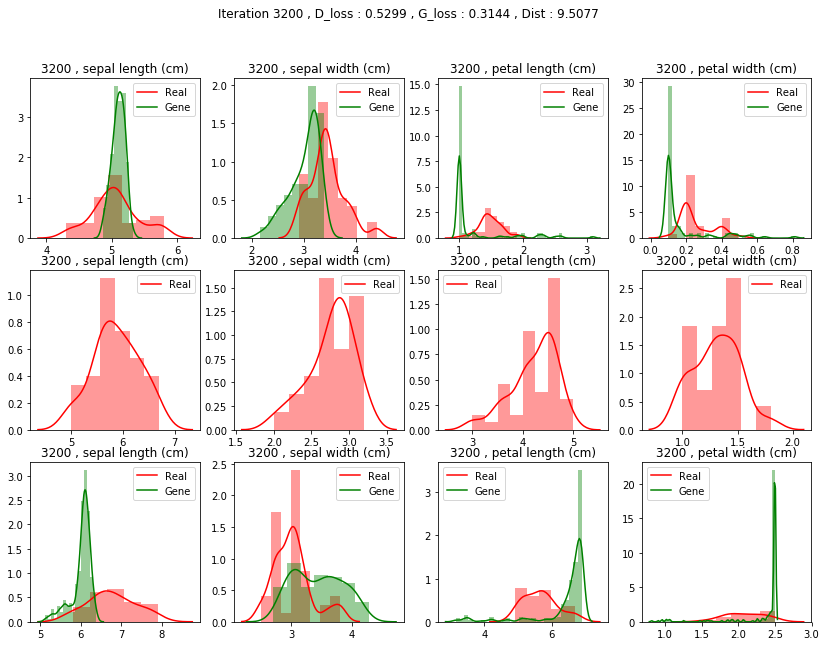

In [ ]:
if __name__ == "__main__" :
    main()

* 흥미로운점은 Species 같은 경우 [-1 , 0 , 1 ] 로 minmax scaling을 한 다음에 생성을 시킴
    * 생성물은 -1 , 1 사이에서 데이터를 생성후 Round를 하여서 사용함.
    * 그래서 기대하는 것은 생성되는 것이 수치형으로 나오지만 -1 , 0 , 1 주변으로 모이면서 생성되는 것을 기대함.
    * 실제 결과도 -1 , 0 , 1 주변으로 모이는 것이 확인함.
* softmax로 생성시
    * 문제가 생기는 것은 3클래스를 생성시키는 것을 원하는데 2가지 클래스나 1개 클래스만 생성되는 경우가 지속적으로 발생함.
    * 흔히 논문에서는 wgan을 활용해서하면, 효과가 좋다고 이야기하고 있어서 진행중
    * **발견!** 선형과 섞어주니까 좀 더 고르게 나오게 되는듯
        * 더 깊게해도 잘 될까?

In [ ]:
import os
os.system('convert -delay 30 -loop 0 ./gan_result/*png ./gan_result/simulation.gif')

In [ ]:
#x_plot
g_plot = sess.run(G_sample)
g_plot[:,:4] = scaler.inverse_transform(g_plot[:,:4])
g_plot = np.concatenate((g_plot[:,:4] , np.argmax(g_plot[:,4:],1)[:,np.newaxis] ), axis = 1)

## Species도 같이 시각화하기

In [ ]:
            ## 버전 
#             fig = plt.figure(figsize = (20,10))
#             ax1 = fig.add_subplot(231)
#             ax2 = fig.add_subplot(232)
#             ax3 = fig.add_subplot(233)
#             ax4 = fig.add_subplot(234)
#             ax5 = fig.add_subplot(235)
#             ax6 = fig.add_subplot(236)
#             ax1.title.set_text(feature[0])
#             ax2.title.set_text(feature[1])
#             ax3.title.set_text(feature[2])
#             ax4.title.set_text(feature[3])
#             ax5.title.set_text("Species")
#             ax6.title.set_text("Rounded Species")
#             dist = 0
#             for n in np.arange(4) :
#                 dist += was_dist(x_plot[:,n], g_plot[:,n])
#             sns.distplot(x_plot[:,0], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax1)
#             sns.distplot(g_plot[:,0], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax1)
#             sns.distplot(x_plot[:,1], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax2)
#             sns.distplot(g_plot[:,1], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax2)
#             sns.distplot(x_plot[:,2], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax3)
#             sns.distplot(g_plot[:,2], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax3)
#             sns.distplot(x_plot[:,3], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = ax4)
#             sns.distplot(g_plot[:,3], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = ax4)
#             sns.distplot(x_plot[:,4], kde_kws ={"color": "r", "label" : "Real"} , hist = False  , ax = ax5)
#             sns.distplot(g_plot[:,4], kde_kws ={"color": "g", "label" : "Gene"} , hist = False , rug = True  , ax = ax5)
#     #         sns.distplot(x_plot[:,4], kde_kws ={"color": "r", "label" : "Real"} , hist = False  , ax = ax6)
#     #         sns.distplot(np.round(g_plot[:,4]), kde_kws ={"color": "g", "label" : "Gene"} , hist = False , rug = True  , ax = ax6)
#             plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, dist) )
            #plt.tight_layout()
#             plt.savefig('./gan_result/iteration_%d.png'%i)
#             plt.show()

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(14, 10))
axx = ax.flatten()
num = 0
total_dist = 0
for i in [0,1,2] :
    real_idx = x_plot[:,4] == i
    fake_idx = g_plot[:,4] == i 
    dist = 0
    for n in np.arange(4) :
        try :
            dist += was_dist(x_plot[real_idx,n], g_plot[fake_idx,n])
            total_dist += dist 
        except Exception as e :
            pass
        sns.distplot(x_plot[real_idx,n], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
        sns.distplot(g_plot[fake_idx,n], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
        axx[num].set_title("{} , {}".format(i , feature[n]))
        num +=1
plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
plt.show()